In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import seaborn as sbn
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

### Question 1. Fit a polynomial model 
of degree $M=10$ to the data below. Perform Lasso regularization, fitting the model over data1_1, selecting the optimal value of the regularization parameter over the data1_2 (based on validation R2) and testing performance over the data1_3.

Important - standardize the data before training Lasso model and apply the same $\mu$ and $\sigma$ defined over data1_1 to data1_2 and data1_3 during validation/testing (as we are not supposed to learn anything, including normalization coefficients from validation and test data; all the parameters of the model are to be learned from training data exclusively).

Visualize the final model against all the data from from training, validation and test samples on the same plot using different colors for points from different samples. For comparison also visualize the true model used to generate the data below - $y=x^4/100+x^3/20+x^2/3+2$.

Output the coefficients of the model.

In [2]:
#generate data and put it in the dataframe
np.random.seed(2018)
x=np.arange(-10,20,0.5)
y=x**4/100+x**3/20+x**2/3+2*x+np.random.normal(loc=0,scale=3,size=60)
data1=pd.DataFrame({'x':x,'y':y}) #create a dataframe
#slice the data in three pieces (we'll talk about those later)
data1_2=data1.loc[40:49]
data1_3=data1.loc[50:59]
data1=data1.loc[0:39] 
data1.head() #for now let's stick with this first one

,x,y
0,-10.0,62.503031
1,-9.5,51.410761
2,-9.0,44.605198
3,-8.5,24.739247
4,-8.0,22.200164


In [3]:
#generate regressors for data1, data1_2, data1_3
M=10
for p in range(1,M+1): #add more powers of x up to 10'th
    data1['x%d'%p]=data1.x**p

for p in range(1,M+1): #add more powers of x up to 10'th
    data1_2['x%d'%p]=data1_2.x**p

for p in range(1,11): #add more powers of x up to 10'th
    data1_3['x%d'%p]=data1_3.x**p

In [4]:
#consider just the model of degree M=10
regressors=['x%d'%p for p in range(1,11)]
data2=data1[['y']+regressors]
data2V=data1_2[['y']+regressors]
data2T=data1_3[['y']+regressors]
data2.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,62.503031,-10.0,100.00,-1000.000,10000.0000,-100000.00000,1000000.000000,-1.000000e+07,1.000000e+08,-1.000000e+09,1.000000e+10
1,51.410761,-9.5,90.25,-857.375,8145.0625,-77378.09375,735091.890625,-6.983373e+06,6.634204e+07,-6.302494e+08,5.987369e+09
2,44.605198,-9.0,81.00,-729.000,6561.0000,-59049.00000,531441.000000,-4.782969e+06,4.304672e+07,-3.874205e+08,3.486784e+09
3,24.739247,-8.5,72.25,-614.125,5220.0625,-44370.53125,377149.515625,-3.205771e+06,2.724905e+07,-2.316169e+08,1.968744e+09
4,22.200164,-8.0,64.00,-512.000,4096.0000,-32768.00000,262144.000000,-2.097152e+06,1.677722e+07,-1.342177e+08,1.073742e+09


In [5]:
#standardise the data including validation and test sets (using normalization learned from training)
for c in data2.columns:
    mu=data2[c].mean()
    sigma=data2[c].std()
    data2[c]=(data2[c]-mu)/sigma

/home/jaime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [6]:
data2.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0.742718,-1.668028,2.199702,-2.541614,2.931891,-3.167832,3.489847,-3.666679,3.941210,-4.078706,4.314933
1,0.493424,-1.582488,1.877794,-2.169821,2.251373,-2.432833,2.409703,-2.532217,2.446065,-2.531933,2.406006
2,0.340472,-1.496948,1.572395,-1.835176,1.670230,-1.837310,1.579331,-1.704712,1.411245,-1.516109,1.216404
3,-0.106006,-1.411408,1.283503,-1.535721,1.178283,-1.360398,0.950218,-1.111576,0.709485,-0.864338,0.494227
4,-0.163071,-1.325868,1.011120,-1.269504,0.765900,-0.983425,0.481291,-0.694658,0.244308,-0.456889,0.068448


In [7]:
#fit Lasso for various alpha and tune it to optimize Validation R2
Lasso=linear_model.Lasso(fit_intercept=True, alpha=0.463) 
Lasso.fit(data2[regressors],data2.y)
data2V['yLpred']=Lasso.predict(data2V[regressors])
ValidR2=1-((data2V.yLpred-data2V.y)**2).sum()/((data2V.y-data2V.y.mean())**2).sum(); ValidR2

0.97147745391050044

In [8]:
Lasso.coef_

array([ 0.10501593,  0.26421743,  0.        ,  0.01426533,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [9]:
#report test R2
data2T['yLpred']=Lasso.predict(data2T[regressors])
TestR2=1-((data2T.yLpred-data2T.y)**2).sum()/((data2T.y-data2T.y.mean())**2).sum(); TestR2

0.93518336369424049

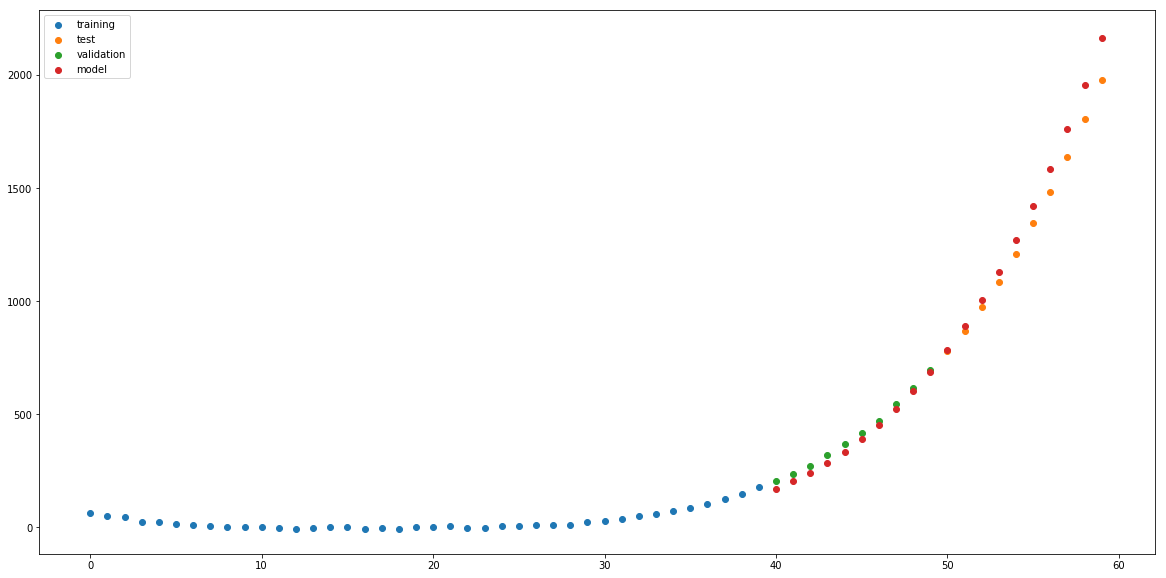

In [10]:
#visualize the model against all the data from training, validation and test samples
plt.figure(figsize=(20, 10))
plt.scatter(range(0, 40), data1['y'])
plt.scatter(range(50, 60), data2T['y'])
plt.scatter(range(40, 50), data2V['y'])
plt.scatter(range(40, 60), np.concatenate([data2V['yLpred'].values, data2T['yLpred'].values]))
plt.legend(labels=['training', 'test', 'validation', 'model'])
plt.show()

### Question 2. P-values and hypothesis testing
Suppose that a multiple regression with 7 regressors gave the following p-values for each of them:
0.02, 0.1, 3e-15, 0.04, 0.001, 0.06, 0.03.

For how many regressors you would reject the null-hypothesis that their corresponding regression coefficient is zero at the 95% confidence level? Please explain.

In [11]:
# Answer here
# We may drop features with p-values larger than 0.05. In this case, 2nd and 6th regressors should be removed.

### Question 3. Confidence intervals
Assume we perform a regression and get an estimate 10 for the slope coefficient for the regressor of interest. Select all statements that can not be true for its confidence intervals:

a. 95%-confidence interval is [-5, 5]

b. 99%-conficence interval is [9.99,10.01]

c. 95%-confidence interval is [9,100]

d. 99%-confidence interval is [8, 12], while 95%-confidence interval is [9, 11].

Explain your choices

#### Answer: A,C.

1.The confidence interval should be centered around 10, so A, C are false.

2.D is possible since 99% CI should be larger than 95%.

# Principal component regression

### Question 4

Using the median price per sq.foot from Zillow data below as reported for 2018-08, fit the linear model using N leading principal components of the 311 data and perform cross-validation. Visualize performance depending on the number N of leading PCs. Specifically: 
    1. implement a 20-times-cross-validation as a function of N returing OS R2
    2. run it for N=1,2,...30, return the best N and the corresponding R2
    3. mark it with a vertical line on the plot and put the value of N and the corresponding R2 as text labels
**Important:** keep training pca over the training sample only, applying the same pca transform to the test samples in order to prepare regressors for them

In [12]:
# Write code here
zillow=pd.read_csv("data/Zip_MedianListingPricePerSqft_AllHomes.csv",index_col=0)
zillow.head()

,City,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
RegionName,,,,,,,,,,,,,,,,,,,,,
10023,New York,NY,"New York, NY",New York,1,NaN,NaN,NaN,NaN,1366.621067,...,1954.992968,1983.055556,1963.986600,1702.573836,1522.948540,1568.100358,1612.378790,1569.371728,1599.538839,1619.794484
60614,Chicago,IL,"Chicago, IL",Cook,2,347.391304,333.975410,332.666667,324.490763,325.832510,...,514.255544,522.193211,519.321330,520.408163,476.592732,463.928571,470.769231,461.960986,455.861397,436.111111
79936,El Paso,TX,"El Paso, TX",El Paso,3,88.688320,88.159032,87.940589,87.929656,87.368706,...,88.419016,88.540363,88.755279,88.455330,88.367347,89.118199,90.128755,90.316333,90.726125,91.668726
10002,New York,NY,"New York, NY",New York,4,NaN,NaN,NaN,NaN,NaN,...,2041.247701,2043.165468,2063.785322,2012.302285,2015.369804,2026.353276,2022.274326,2013.831259,1997.942387,2030.259366
926,San Juan,TX,"Brownsville, TX",Cameron,5,NaN,NaN,NaN,NaN,NaN,...,92.968750,92.954963,93.776641,92.968750,95.090118,103.846154,100.411523,108.447489,102.270729,102.270729


**Load/process 311 data**

In [13]:
data311 = pd.read_csv( 'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [14]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [15]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [16]:
ZillowData=zillow.merge(data311,left_index=True,right_index=True)
zdata=ZillowData.iloc[:,109:]
Z=ZillowData['2018-08']

In [17]:
def CrossValid(N,output=False):
    np.random.seed(0)
    # Apply cross-validation to diagnose model for overfitting
    R_IS=[]; R_OS=[] #lists for recording in-sample (training) and out-of-sample (test) R2
    n=20 #number of runs
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(zdata.iloc[:,:],Z,test_size=0.3) #randomly split data into training (70%) and test (30%)
        #now apply PCA to the training data
        pca = PCA(N) #take only 5 leading principal components to get enough data but avoid overfitting
        P_train=pca.fit_transform(X_train)
        res=sm.OLS(y_train,sm.add_constant(P_train)).fit()
        #and apply the same rotation transform we learned for training sample to the test sample
        #this is important that we learn PCA transform from the training sample only rather than from both - training and test
        #as this is part of the principle component regression we need to train; and all training should happen over the training set
        P_test=pca.transform(X_test)
        y_pred=np.asarray(res.predict(sm.add_constant(P_test)))

        R_IS.append(res.rsquared)                                                                     
        R_OS.append(1-((y_pred-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
    if output:    
        print("IS R-squared is %.3f+-%.3f"%(np.mean(R_IS),np.std(R_IS)))
        print("OS R-squared is %.3f+-%.3f"%(np.mean(R_OS),np.std(R_OS)))
    return np.mean(R_OS)  

In [20]:
#find OS R2 for each N
OS_R2=[CrossValid(n, True) for n in range(1,31)]

IS R-squared is 0.215+-0.232
OS R-squared is 0.111+-0.205
IS R-squared is 0.806+-0.019
OS R-squared is 0.803+-0.039
IS R-squared is 0.811+-0.019
OS R-squared is 0.798+-0.039
IS R-squared is 0.818+-0.023
OS R-squared is 0.801+-0.040
IS R-squared is 0.843+-0.026
OS R-squared is 0.813+-0.048
IS R-squared is 0.851+-0.025
OS R-squared is 0.806+-0.047
IS R-squared is 0.858+-0.027
OS R-squared is 0.799+-0.054
IS R-squared is 0.869+-0.026
OS R-squared is 0.792+-0.057
IS R-squared is 0.879+-0.025
OS R-squared is 0.794+-0.045
IS R-squared is 0.890+-0.018
OS R-squared is 0.804+-0.045
IS R-squared is 0.894+-0.018
OS R-squared is 0.803+-0.050
IS R-squared is 0.900+-0.017
OS R-squared is 0.799+-0.049
IS R-squared is 0.904+-0.015
OS R-squared is 0.806+-0.044
IS R-squared is 0.909+-0.014
OS R-squared is 0.814+-0.051
IS R-squared is 0.912+-0.013
OS R-squared is 0.820+-0.054
IS R-squared is 0.913+-0.012
OS R-squared is 0.821+-0.055
IS R-squared is 0.915+-0.012
OS R-squared is 0.818+-0.055
IS R-squared i

Text(16.5,0.85,'Best R2=0.821')

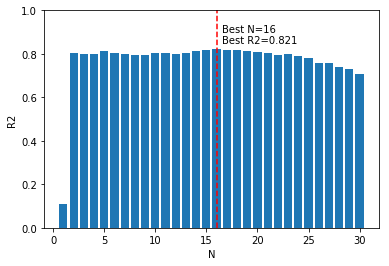

In [19]:
plt.bar(range(1,31),OS_R2,align='center')
N=np.argmax(OS_R2)+1
plt.axvline(N,color='r',linestyle='--')
plt.ylim(0,1)
plt.xlabel('N')
plt.ylabel('R2')
plt.text(N+0.5,0.9,'Best N=%d'%N)
plt.text(N+0.5,0.85,'Best R2=%.3f'%np.max(OS_R2))

### Question 5
1. Using the Zillow dataset from question 4, run PCA on the price dynamics for zip codes over the last 5 years 
    1. take only those zip codes within NYC having price defined for the last 60 months from 2013-09 till 2018-08:
    2. normalize each zip code timeline by average price over this period
    3. standardize those normalized prices per month and use them as features
    4. run pca over those features

2. Visualize zip codes in the 2d space of first two principal components, coloring them by borough (feel free to use borough definition from the class notebook). 

In [29]:
# Write code here
ztimeline=zillow.iloc[:,-60:].dropna()

In [30]:
ztimeline=ztimeline.iloc[(ztimeline.index>=10000)&(ztimeline.index<11500),:] #take only NYC zip codes

In [31]:
ztimeline.shape

(126, 60)

In [32]:
ztimeline.head()

,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
RegionName,,,,,,,,,,,,,,,,,,,,,
10023,1671.539961,1692.579505,1671.539961,1626.483292,1687.241963,1679.678610,1647.985348,1602.992987,1693.398425,1679.748823,...,1954.992968,1983.055556,1963.986600,1702.573836,1522.948540,1568.100358,1612.378790,1569.371728,1599.538839,1619.794484
10016,1208.647968,1240.693215,1338.257652,1288.714051,1341.698842,1287.390942,1290.475408,1361.205586,1357.735068,1343.503937,...,1546.285641,1557.564684,1538.800705,1345.275276,1327.586207,1389.792068,1433.631891,1433.902938,1444.833625,1456.997085
11235,442.216981,442.743009,437.367117,436.607143,436.303571,435.454545,430.821918,435.342870,434.631891,440.149254,...,589.335828,581.314948,578.947368,566.937120,561.356996,582.314205,584.002443,576.515881,577.477570,575.000000
10029,925.000000,946.875000,857.605178,825.504587,857.682409,877.767897,909.326186,1000.175070,940.169668,911.674923,...,1288.980433,1288.980433,1282.051282,1265.954845,1235.999167,1255.656109,1266.935681,1269.503546,1251.968504,1241.534989
10462,149.961919,149.020375,152.517483,153.395836,156.815440,156.001180,156.626733,160.087419,157.142857,157.142857,...,196.202532,200.000000,198.666667,217.787837,220.000000,223.846154,234.939759,228.492107,226.363636,218.090909


In [33]:
ztimeline=ztimeline.div(ztimeline.mean(axis=1), axis=0)

In [34]:
scalerZtime = preprocessing.StandardScaler().fit(ztimeline)
ztimelineS=scalerZtime.transform(ztimeline)

In [35]:
# create borough labels 
Z=np.array(ztimeline.index)
manhattanInd=(Z>10000)&(Z<10300) #Manhattan
statenInd=(Z>=10300)&(Z<10400) #Staten Island
brooklynInd=(Z>=11000)&(Z<11300) #Brooklyn
queensInd=(Z>=11300)&(Z<11500) #Queens
bronxInd=(Z>=10400)&(Z<10500) #Bronx
#create an array of the same length as data311 index providing the borough number
DZ=Z*0
DZ[manhattanInd]=1
DZ[statenInd]=2
DZ[brooklynInd]=3
DZ[queensInd]=4
DZ[bronxInd]=5

In [36]:
#perform PC decomposition
pca = PCA(2)
ZP=pca.fit_transform(ztimeline)

In [37]:
ZP.shape

(126, 2)

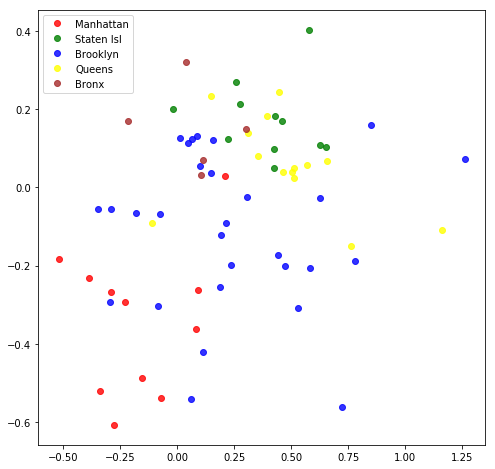

In [38]:
#2-d plot
colors=('gray','red','green','blue','yellow','brown')
fig = plt.figure(figsize=(8,8))
for d in range(1,6):
    plt.plot(np.array(ZP[DZ==d,0]), np.array(ZP[DZ==d,1]),
        'o', color=colors[d], alpha=0.8, label=d)
plt.legend(['Manhattan','Staten Isl','Brooklyn','Queens','Bronx'],loc='upper left')